In [2]:
import pandas as pd
import numpy as np 

from pathlib import Path

In [10]:
from gensim import corpora
from gensim.parsing.preprocessing import strip_non_alphanum, strip_numeric
from gensim.parsing.preprocessing import strip_punctuation, strip_short, remove_stopwords
from gensim.parsing.preprocessing import preprocess_string
from gensim.utils import lemmatize
from gensim.parsing.preprocessing import STOPWORDS as gs_stopwords

In [4]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [5]:
docdir = Path('../data/docs')

In [6]:
raw_corpus = []

In [7]:
files = list(docdir.glob('*.body'))
for f in files:
    with open(f, 'r') as fp:
        raw_corpus.append(fp.read())
        fp.close()

In [40]:
corpus = []
for doc in raw_corpus:
    # from this lemmatization tutorial
    # https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
    lemmatized = [wd.decode('utf-8').split('/')[0] for wd in lemmatize(doc, stopwords=gs_stopwords, min_length=4)]
    corpus.append(lemmatized)


In [41]:
dictionary = corpora.Dictionary(tokens for tokens in corpus)

2019-02-24 14:00:02,754 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2019-02-24 14:00:02,838 : INFO : built Dictionary(4417 unique tokens: ['acquisition', 'aircraft', 'authorize', 'available', 'capital']...) from 1248 documents (total 93137 corpus positions)


In [13]:
tokened_corpus = [dictionary.doc2bow(tokens) for tokens in corpus ]

In [14]:
# dimensionality reduction
from gensim.models import TfidfModel, LsiModel

# first convert words to tfidf values
tfidf = TfidfModel(dictionary=dictionary, normalize=True)
vectored_corpus = [ tfidf[doc] for doc in tokened_corpus]

In [15]:
# next do dimensionalty reduction
lsi = LsiModel(corpus=vectored_corpus, num_topics=200, id2word=dictionary, onepass=False, power_iters=3)

2019-02-23 19:16:56,510 : INFO : using serial LSI version on this node
2019-02-23 19:16:56,511 : INFO : updating model with new documents
2019-02-23 19:16:56,512 : INFO : using 100 extra samples and 3 power iterations
2019-02-23 19:16:56,512 : INFO : 1st phase: constructing (4417, 300) action matrix
2019-02-23 19:16:56,514 : INFO : PROGRESS: at document #0
2019-02-23 19:16:56,621 : INFO : running power iteration #1
2019-02-23 19:16:56,634 : INFO : PROGRESS: at document #0/1248
2019-02-23 19:16:56,713 : INFO : running power iteration #2
2019-02-23 19:16:56,718 : INFO : PROGRESS: at document #0/1248
2019-02-23 19:16:56,788 : INFO : running power iteration #3
2019-02-23 19:16:56,793 : INFO : PROGRESS: at document #0/1248
2019-02-23 19:16:56,870 : INFO : 2nd phase: constructing (300, 300) covariance matrix
2019-02-23 19:16:56,871 : INFO : PROGRESS: at document #0/1248
2019-02-23 19:16:56,902 : INFO : running dense decomposition on (300, 300) covariance matrix
2019-02-23 19:16:56,930 : INFO

In [16]:
lsi_corpus = [ lsi[doc] for doc in vectored_corpus ]

lsi_array = np.array(lsi_corpus)
lsi_array = lsi_array[:,:,1]
lsi_array.shape

(1248, 200)

In [17]:
from gensim import similarities

index = similarities.MatrixSimilarity(lsi_corpus)

2019-02-23 19:17:00,343 : WARNING : scanning corpus to determine the number of features (consider setting `num_features` explicitly)
2019-02-23 19:17:00,361 : INFO : creating matrix with 1248 documents and 200 features


In [18]:
sims = index[lsi_corpus]


In [19]:
sims.shape

(1248, 1248)

In [20]:
df = pd.DataFrame(sims).agg(np.mean).sort_values().head(10)

In [21]:
df

930     0.012042
271     0.013199
967     0.013199
352     0.014439
763     0.016221
806     0.016221
90      0.017107
575     0.017672
804     0.018047
1077    0.018047
dtype: float32

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a287d9240>,
      dtype=object)

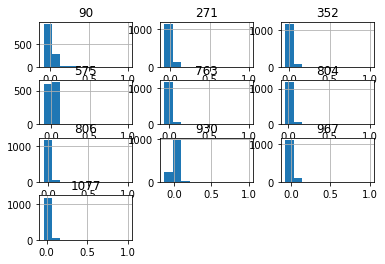

In [22]:
%matplotlib inline 
pd.DataFrame(sims).loc[:,df.index].hist()

In [25]:
raw_corpus[271]

'731.Unless otherwise authorized by existing law, none of the funds provided in this or any other Act may be used by an executive branch agency to produce any prepackaged news story intended for broadcast or distribution in the United States, unless the story includes a clear notification within the text or audio of the prepackaged news story that the prepackaged news story was prepared or funded by that executive branch agency.'

In [26]:
corpus[271]

['authorize',
 'exist',
 'fund',
 'provide',
 'executive',
 'branch',
 'agency',
 'produce',
 'prepackage',
 'news',
 'story',
 'intend',
 'broadcast',
 'distribution',
 'united',
 'states',
 'story',
 'include',
 'clear',
 'notification',
 'text',
 'audio',
 'prepackage',
 'news',
 'story',
 'prepackage',
 'news',
 'story',
 'prepare',
 'fund',
 'executive',
 'branch',
 'agency']

In [27]:
dictionary.token2id['butterfly']

2136

In [28]:
for i, doc in enumerate(tokened_corpus):
    for entry in doc:
        if entry[0] == 2136:
            print(i)

234


In [30]:
# cluster with hdbscan
import hdbscan
hdb = hdbscan.HDBSCAN()
hdb.fit(lsi_array)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=False, leaf_size=40,
    match_reference_implementation=False, memory=Memory(location=None),
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
    prediction_data=False)

In [31]:
hdb.labels_

array([-1, -1,  2, ...,  2, -1,  2])

In [32]:
hdb.labels_.max()

3

In [33]:
outlier_docs = []

for index, label in enumerate(hdb.labels_):
    if label == -1:
        outlier_docs.append(index)

In [34]:
len(outlier_docs)

471

In [35]:
lsi_array.shape

(1248, 200)